In [26]:
# Импортируем необходимые модули
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import xgboost as xgb
import glob

# Импортируем необходимые функции
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
from tqdm import tqdm

INFO:pycodestyle:1:1: E265 block comment should start with '# '
INFO:pycodestyle:10:1: E265 block comment should start with '# '


In [115]:
# Скачивание данныъх
data = pd.read_csv(
    "https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv"
    )

# Разбиваем данные на трейн тест
x_train = data.iloc[:-80]
x_test = data.iloc[-80:]

y_train = data['aqi'].iloc[:-80]
y_test = data['aqi'].iloc[-80:]

INFO:pycodestyle:3:80: E501 line too long (114 > 79 characters)


In [116]:
# Просмотрим датасет
data.tail(3)

,CO_Concentration,NO2_Concentration,O3_Concentration,PM10_Concentration,PM2.5_Concentration,SO2_Concentration,Date,SO2_index,PM10_index,PM2.5_index,O3_index,NO2_index,CO_index,aqi
2919,0.484167,25.388060,26.164896,20.801250,12.007071,NaN,2020-12-29,0,19,50,24,12,0,50
2920,0.482083,27.360107,26.609375,14.592212,12.870614,NaN,2020-12-30,0,13,52,24,13,0,52
2921,0.454583,28.051677,NaN,15.820345,NaN,NaN,2020-12-31,0,14,0,0,14,0,14


In [117]:
# Формируем датасет False True(пропущенное значение) для анализа пропусков
missval_df_train = data.isnull()
for column in missval_df_train.columns.values.tolist():
    print(column)
    print(missval_df_train[column].value_counts(), '\n')

In [118]:
# Преобразуем исходнные данные
# для построения модели на всех "подиндексах" качества воздуха.

# Формируем тренировочный и тестовый датасеты
df_xtrain = DataFrame(
    x_train[["CO_index", "PM10_index", "PM2.5_index",
             "SO2_index", "O3_index", "NO2_index"]]
             )
df_xtest = DataFrame(
    x_test[["CO_index", "PM10_index", "PM2.5_index",
            "SO2_index", "O3_index", "NO2_index"]]
            )

# Cформируем датасеты для построения временного окна
dfxtrain = DataFrame()
dfxtest = DataFrame()

# Выполняеv построение временного окна
# (путем сдвига исходного датасета)
for i in df_xtrain:
    dfxtrain[f'{i}'] = df_xtrain[i].shift(1)
for i in df_xtrain:
    dfxtrain[f'{i}2'] = df_xtrain[i].shift(2)
# Test
for i in df_xtest:
    dfxtest[f'{i}'] = df_xtest[i].shift(1)
for i in df_xtest:
    dfxtest[f'{i}2'] = df_xtest[i].shift(2)

# Конвертируем исходные массив NumPy с ответами
# в Датафрейм для объединения

y_train = DataFrame(y_train)
y_test = DataFrame(y_test)

# Сформируем объединенный датасет
# 'сдвинутые индексы качесва воздуха' - 'True values'
# (Делаем это для сохранения соответсвия между подиндексами и реальным индексом качества воздуха)

frames1 = [y_train, dfxtrain]
frames2 = [y_test, dfxtest]

results1 = concat(frames1, axis=1)
results1 = results1.dropna()

results2 = concat(frames2, axis=1)
results2 = results2.dropna()

# Cформируем заключительный датасет трейн и тест

# Train
y_train = DataFrame(results1['aqi'])
x_train = results1

# Test
y_test = DataFrame(results2['aqi'])
x_test = results2

del x_train['aqi']
del x_test['aqi']

INFO:pycodestyle:38:80: E501 line too long (97 > 79 characters)


Выполним обучение XGBBost.

In [119]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50, verbose=False)

XGBRegressor()

Оценим важность признаков.

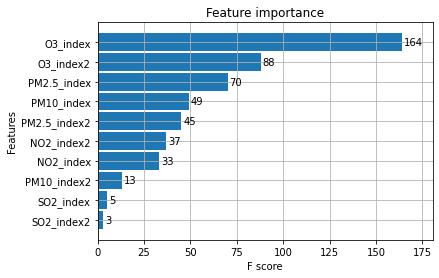

In [120]:
_ = xgb.plot_importance(reg, height=0.9)

Визуализируем соответсвие предсказанных данных и исходного временного ряда

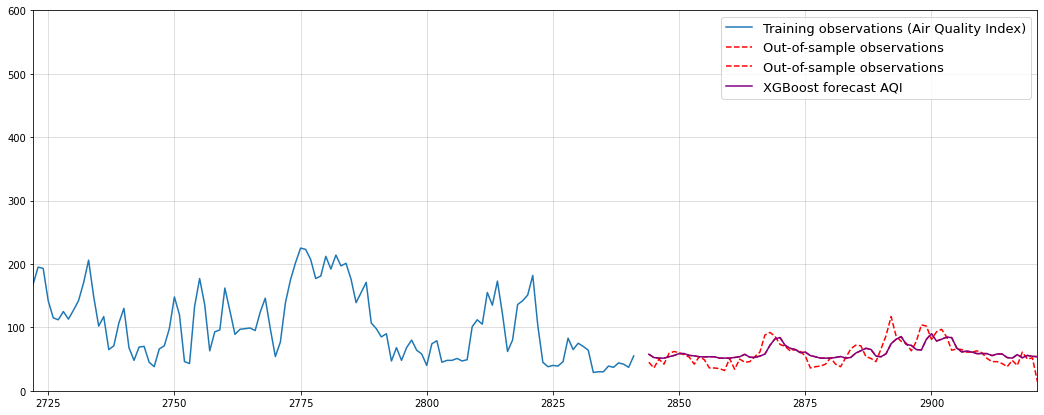

INFO:pycodestyle:8:80: E501 line too long (80 > 79 characters)


In [121]:
prediction = reg.predict(x_test)
results = DataFrame(y_test)
results['Prediction'] = prediction
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(y_train.iloc[-120:], label="Training observations (Air Quality Index)")
plt.plot(y_test, color="red", label="Out-of-sample observations", ls="dashed")

plt.plot(results['Prediction'], color="purple", label="XGBoost forecast AQI")

plt.legend(fontsize=13)
plt.margins(x=0)

Оценим ошибку (MAE)

In [122]:
error = mean_absolute_error(y_test['aqi'], prediction)
error

10.481111624302008

Вследствие временного лага заложенного в обучаемых данных, и по графику виден лаг. Посчитаем ошибку сдвинув предказанное на этот лаг.

In [123]:
shift_prediction = DataFrame(prediction)
shift_prediction = shift_prediction.shift(-2)
shift_prediction.drop([76, 77], inplace=True)
y = y_test['aqi']
y = y.reset_index(drop=True)
y.drop([76, 77], inplace=True)
error = mean_absolute_error(y, shift_prediction)
error

8.245970173885947

Попробуем предсказывать по 1 дню, пересчитывая предикт каждый день.<br>
Предсказываем на 48 дней вперед.<br>
Визуализируем это.<br>

In [124]:
df = data[["CO_index", "PM10_index", "PM2.5_index", "SO2_index", "O3_index", "NO2_index"]]
y = DataFrame(y_test['aqi'])
x = df[-48:].fillna(x_test.mean())
testx = DataFrame()

for i in x:
    testx[f'{i}'] = x[i].shift(1)
for i in x:
    testx[f'{i}2'] = x[i].shift(2)

x = testx
samples = []

INFO:pycodestyle:1:80: E501 line too long (90 > 79 characters)


In [125]:
for i in range(48):
    # сохраняйте запаздывающей функции для каждого периода
    Xf = np.concatenate([x.iloc[-1, 1:].values.reshape(1, -1),
                         y.iloc[-1].values.reshape(1, 1)], 1)
    Xf = DataFrame(Xf)
    forecast = []
    Xf.columns = ["CO_index", "PM10_index", "PM2.5_index", "SO2_index", "O3_index", "NO2_index", "CO_index2", "PM10_index2", "PM2.5_index2", "SO2_index2", "O3_index2", "NO2_index2"]

    for t in range(10000):
        pred = reg.predict(Xf)[0]
        forecast.append(pred)
        Xf = Xf.to_numpy()
        # update lagged features for next period
        Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)
        Xf = DataFrame(Xf)
        Xf.columns = ["CO_index", "PM10_index", "PM2.5_index", "SO2_index", "O3_index", "NO2_index", "CO_index2", "PM10_index2", "PM2.5_index2", "SO2_index2", "O3_index2", "NO2_index2"]
    samples.append(forecast)

INFO:pycodestyle:7:80: E501 line too long (181 > 79 characters)
INFO:pycodestyle:16:80: E501 line too long (185 > 79 characters)


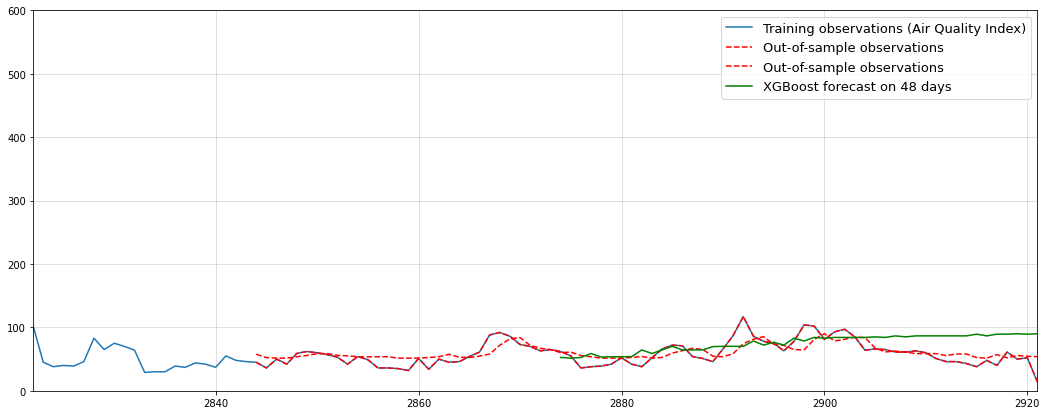

INFO:pycodestyle:5:80: E501 line too long (84 > 79 characters)
INFO:pycodestyle:6:80: E501 line too long (90 > 79 characters)
INFO:pycodestyle:7:80: E501 line too long (103 > 79 characters)


In [126]:
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(data['aqi'].iloc[-100:], label="Training observations (Air Quality Index)")
plt.plot(y_test.iloc[-100:], color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(x_test.iloc[30:].index, samples[-1][0:48], color="green", label="XGBoost forecast on 48 days")

plt.legend(fontsize=13)
plt.margins(x=0)